In [1]:
from datasets import load_dataset
data = load_dataset('jamescalam/youtube-transcriptions', split='train')

In [2]:
data

Dataset({
    features: ['title', 'published', 'url', 'video_id', 'channel_id', 'id', 'text', 'start', 'end'],
    num_rows: 208619
})

In [3]:
data.to_pandas().title.nunique()

700

In [4]:
## Prepare Context
# Pandas are used to create the context windows of size 20 with stire 4
# For every 4 sentences, it creates a context by concatenating the next 20 sentences
# Eventually the answers will come from finding to right context and summarizing it.

In [5]:
import numpy as np 
import pandas as pd

window = 20
stride = 4 

In [6]:
def contextualize(raw_df, window, stride):
    def process_video(vid):
        # for each video, create the rolling window
        text = vid.text.values
        time_end = vid['end'].values
        contexts = vid.iloc[:-window:stride, :].copy()
        contexts['text'] = [' '.join(text[start_i:start_i+window])
                            for start_i in range(0, len(vid)-window, stride)]
        contexts['end'] = [time_end[start_i+window-1]
                           for start_i in range(0, len(vid)-window, stride)]
        return contexts
    # concat results from all videos
    return pd.concat([process_video(vid) for _, vid in raw_df.groupby('title')])

df = contextualize(data.to_pandas(), 20, 4)

In [7]:
len(df)

48935

In [8]:
## Create Embedding function 
# Call the OpenAI embedding API to get embeddings

In [9]:
from tqdm.auto import tqdm
import functools
import openai
from retry import retry
import time
import math
import pandas as pd  # assuming you are using pandas for the DataFrame

# Initialize OpenAI API key
openai.api_key = 'sk-***'

# Initialize variables for custom rate limiting
last_called = [0.0]
max_calls = 0.9  # per second
period = 1.0

# Custom rate limiter function
def rate_limiter(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        elapsed = time.time() - last_called[0]
        to_wait = period - elapsed
        if to_wait > 0:
            time.sleep(to_wait)
        last_called[0] = time.time()
        return func(*args, **kwargs)
    return wrapper

# Get the embedding and retry
@retry(tries=10, delay=1, max_delay=30, backoff=3, jitter=1)
@rate_limiter
def embed_func(c):
    rs = openai.Embedding.create(input=c, engine='text-embedding-ada-002')
    return [record['embedding'] for record in rs['data']]

# Function to chunk an array into batches
def to_batches(arr, batch_size):
    length = len(arr)
    def _chunker(arr):
        for start_i in range(0, len(arr), batch_size):
            yield arr[start_i:start_i+batch_size]
    yield from tqdm(_chunker(arr), total=math.ceil(length / batch_size))

# Assuming df is your DataFrame and it has a column named 'text'
batch_size = 1000
batches = to_batches(df.text.values.tolist(), batch_size)

# Perform the rate-limited API calls for each batch
embeds = [emb for batch in batches for emb in embed_func(batch)]



  0%|          | 0/49 [00:00<?, ?it/s]

In [14]:
import lance
import pyarrow as pa 
from lance.vector import vec_to_table 

table = vec_to_table(np.array(embeds))
combined = pa.Table.from_pandas(df).append_column('vector', table['vector'])
dst = lance.write_dataset(combined, "AIchatbot.lance")

In [15]:
ds = dst.create_index('vector',
                     index_type='IVF_PQ',
                     num_partitions=64, # IVF
                     num_sub_vectors=96) # PQ

Sample 16384 out of 48935 to train kmeans of 1536 dim, 64 clusters


In [16]:
def create_prompt(query, context):
    limit = 3750

    prompt_start = (
        "Anwer the question based on the context below. \n \n" + 
        "Context:\n"
    )
    prompt_end = (
        f"\n\nQuestion: {query}\nAnswer:"
    )
    # append contexts until hitting limit 
    for i in range(1, len(context)):
        if len('\n\n---\n\n'.join(context.text[:i])) >= limit:
            prompt = (
                prompt_start + 
                '\n\n---\n\n'.join(context.text[:i-1]) +
                prompt_end
            )
            break
        elif i == len(context)-1:
            prompt = (
                prompt_start +
                '\n\n---\n\n'.join(context.text) +
                prompt_end
            )
    return prompt

In [17]:
def complete(prompt):
    #query text-davinci-003
    res = openai.Completion.create(
        engine='text-davinci-003',
        prompt=prompt,
        temperature=0,
        max_tokens=400,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
        stop=None
    )
    return res['choices'][0]['text'].strip()

# Check if the bot works 
query = "What is mission Chandrayaan-3 and explain its significance?"
complete(query)

"Mission Chandrayaan-3 is an Indian lunar exploration mission that is planned to be launched in 2021. The mission is a follow-up to the Chandrayaan-2 mission, which was launched in 2019 but failed to land on the moon. The mission will involve the launch of an orbiter and a lander, both of which will be sent to the moon. The orbiter will be used to map the lunar surface and study its composition, while the lander will be used to deploy a rover to the moon's surface.\n\nThe mission is significant because it will be the first Indian mission to land on the moon. It will also be the first mission to use an Indian-made lander and rover. The mission will provide valuable data about the moon's surface and composition, which will help scientists better understand the moon's history and evolution. Additionally, the mission will help India become a major player in the space exploration industry."

In [18]:
def answer(question):
    emb = embed_func(question)[0]  # Changed query to question
    context = ds.to_table(
        nearest={
            "column": "vector",
            "k": 3,
            "q": emb,
            "nprobes": 20,
            "refine_factor": 100
        }).to_pandas()
    prompt = create_prompt(question, context)
    return complete(prompt), context.reset_index()

In [19]:
from IPython.display import YouTubeVideo

In [20]:
# Show the answer and show the video at the right place 

In this video, we will build an input pipeline and train a model using a mass language modeling script to mask around 15% of the tokens within the tensor. We will then test the model by replacing one of the words in a sentence with a text and seeing if the model can predict what is there.


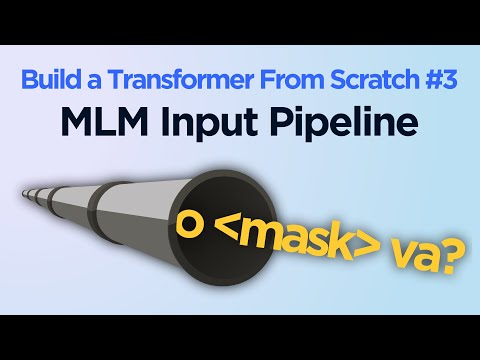

In [21]:
query = ("Training and Testing an Italian BERT - Transformers From Scratch #4")
completion, context = answer(query)

print(completion)
top_match = context.iloc[0]
YouTubeVideo(top_match["url"].split("/")[-1], start=int(top_match["start"]))

In [26]:
%%writefile tuesdai.py

from langchain.chat_models import ChatOpenAI
from langchain.schema import (
    SystemMessage,
    HumanMessage,
    AIMessage
)
import streamlit as st
from streamlit_chat import message
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv(), override=True)

st.set_page_config(
    page_title='T.U.E.S.D.A.I Virtual Assistant',
    page_icon='🤖==>🌮'
)
st.subheader('Taco Bell SD Custom Chatbot 💡')
chat = ChatOpenAI(model_name='gpt-3.5-turbo', temperature=0.5)
if 'messages' not in st.session_state:
    st.session_state.messages = []

with st.sidebar:
    system_message = st.text_input(label='System role')
    user_prompt = st.text_input(label='Send a message')
    if system_message:
        if not any(isinstance(x, SystemMessage) for x in st.session_state.messages):
            st.session_state.messages.append(
                SystemMessage(content=system_message)
            )
    st.write(st.session_state.messages)
    
    if user_prompt:
        st.session_state.messages.append(
            HumanMessage(content=user_prompt)
        )
    
    with st.spinner('🌮 is working on your request...'):
        response = chat(st.session_state.messages)
    st.session_state.messages.append(AIMessage(content=response.content))

st.session_state.messages

Writing tuesdai.py
